# TUTORIAL


In [17]:
from essentials.physical_models import Rijke
from essentials.Util import *

data_folder, results_folder = set_working_directories('rijke')


In [18]:
from essentials.create import create_truth
from essentials.plotResults import plot_truth

truth = create_truth(model=Rijke,
                     manual_bias='time',
                     t_start=.2, 
                     t_stop=1.,
                     dt_obs=20)

plot_truth(**truth, f_max=1200, fig_width=20)


In [19]:
from essentials.create import create_ensemble


ensemble = create_ensemble(model=Rijke,
                           filter='rBA_EnKF',  # 'rBA_EnKF' 'EnKF' 'EnSRKF'
                           est_a=['beta', 'tau'],
                           std_a=dict(beta=[3., 4.], tau=[1e-3, 2e-3]),
                           std_psi=0.25,
                           inflation=1.002,
                           reject_inflation=1.05,
                           m=50
                           )

['beta', 'tau']
here!


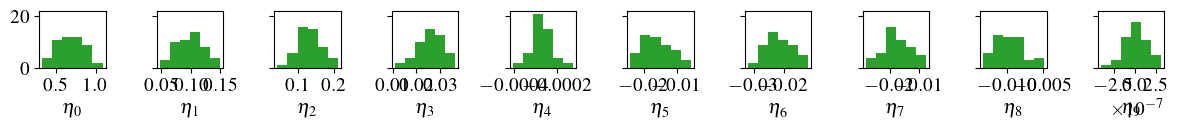

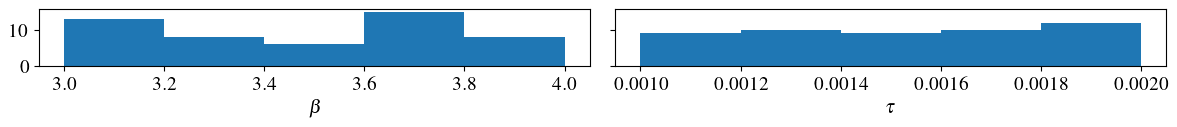

In [20]:
from essentials.plotResults import plot_ensemble

plot_ensemble(ensemble)

Create bias model:  results_rijke/ESN_case_rijke_time
 Run multi-parameter training data: file results_rijke/ESN_case_rijke_time_train_data not found
Rerun training data
['beta', 'tau']
here!

 ----------------- HYPERPARAMETER SEARCH ------------------
 4x4 grid and 4 points with Bayesian Optimization
		 rho	 sigma_in	 tikh	 MSE val 
1	 5.000e-01	 1.000e-05	 1.000e-16	 -4.6784
2	 5.000e-01	 1.000e-04	 1.000e-16	 -4.5929
3	 5.000e-01	 1.000e-03	 1.000e-16	 -4.2680
4	 5.000e-01	 1.000e-02	 1.000e-16	 -4.1402
5	 6.667e-01	 1.000e-05	 1.000e-16	 -4.4823
6	 6.667e-01	 1.000e-04	 1.000e-16	 -4.5840
7	 6.667e-01	 1.000e-03	 1.000e-16	 -4.2822
8	 6.667e-01	 1.000e-02	 1.000e-16	 -4.1574
9	 8.333e-01	 1.000e-05	 1.000e-16	 -4.4824
10	 8.333e-01	 1.000e-04	 1.000e-16	 -4.5516
11	 8.333e-01	 1.000e-03	 1.000e-16	 -4.2689
12	 8.333e-01	 1.000e-02	 1.000e-16	 -4.1821
13	 1.000e+00	 1.000e-05	 1.000e-16	 -3.9912
14	 1.000e+00	 1.000e-04	 1.000e-16	 -4.0552
15	 1.000e+00	 1.000e-03	 1.000e-16	 -3.918

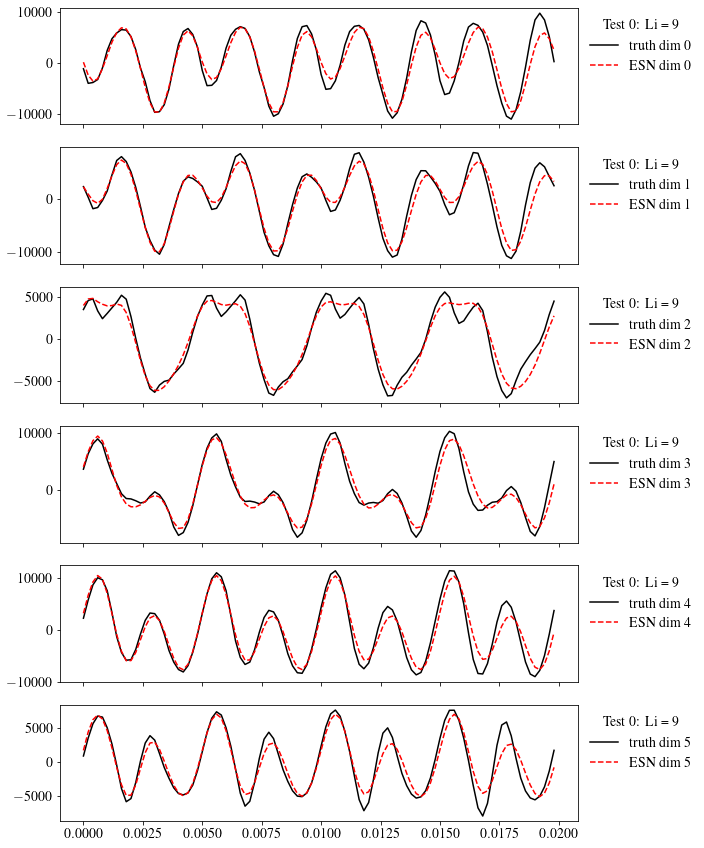

In [21]:
from essentials.bias_models import ESN
from essentials.create import create_bias_model

bias_params = dict(bias_model=ESN,  # ESN / NoBias
                   N_units=100,
                   upsample=2,
                   # Training data generation  options
                   augment_data=True,
                   L=10,
                   est_a=ensemble.est_a,
                   std_a=0.3,
                   # Training, val and wash times
                   t_val=0.02,
                   t_train=0.5,
                   N_wash=20, 
                    # Hyperparameter search ranges
                   rho_range=[0.5, 1.0],
                   tikh_range=np.array([1e-16]),
                   sigma_in_range=[np.log10(1e-5), np.log10(1e-2)]
                   )

filename = f"ESN_case_rijke_{truth['name_bias']}"

bias, wash_obs, wash_t = create_bias_model(ensemble, truth, bias_params, folder='results_rijke/', bias_filename=filename)


In [26]:
from essentials.run import main
filter_ens = ensemble.copy()
filter_ens.bias = bias.copy()

filter_ens.regularization_factor = 5.
filter_ens.filter = 'rBA_EnKF'

filter_ens = main(filter_ens,  y_obs=truth['y_obs'], t_obs=truth['t_obs'], 
                  std_obs=0.1, wash_obs=wash_obs, wash_t=wash_t)


 ------------------ Rijke Model Parameters ------------------ 
	 C1 = 0.05
	 C2 = 0.01
	 L = 1.0
	 Nc = 50
	 Nm = 10
	 beta = 4.0
	 kappa = 1e+05
	 law = sqrt
	 tau = 0.0015
	 xf = 0.2

 ---------------- ESN bias model parameters --------------- 
	 L = 10
	 N_ens = 1
	 N_units = 100
	 N_wash = 20
	 bayesian_update = False
	 connect = 3
	 observed_idx = [ 6  7  8  9 10 11]
	 perform_test = True
	 rho = 0.5
	 sigma_in = 1e-05
	 t_train = 0.5
	 t_val = 0.02
	 tikh = 1e-16
	 update_reservoir = False
	 upsample = 2

 -------------------- ASSIMILATION PARAMETERS -------------------- 
 	 Filter = rBA_EnKF  
	 bias = ESN 
 	 m = 50 
 	 Time steps between analysis = None 
 	 Inferred params = ['beta', 'tau'] 
 	 Inflation = 1.002 
 	 Ensemble std(psi0) = 0.25
 	 Ensemble std(alpha0) = {'beta': [3.0, 4.0], 'tau': [0.001, 0.002]}
 	 Number of analysis steps = 400, t0=0.2, t1=0.998
	 Bias penalisation factor k = 5.0

 --------------------------------------------
Elapsed time to first observation:

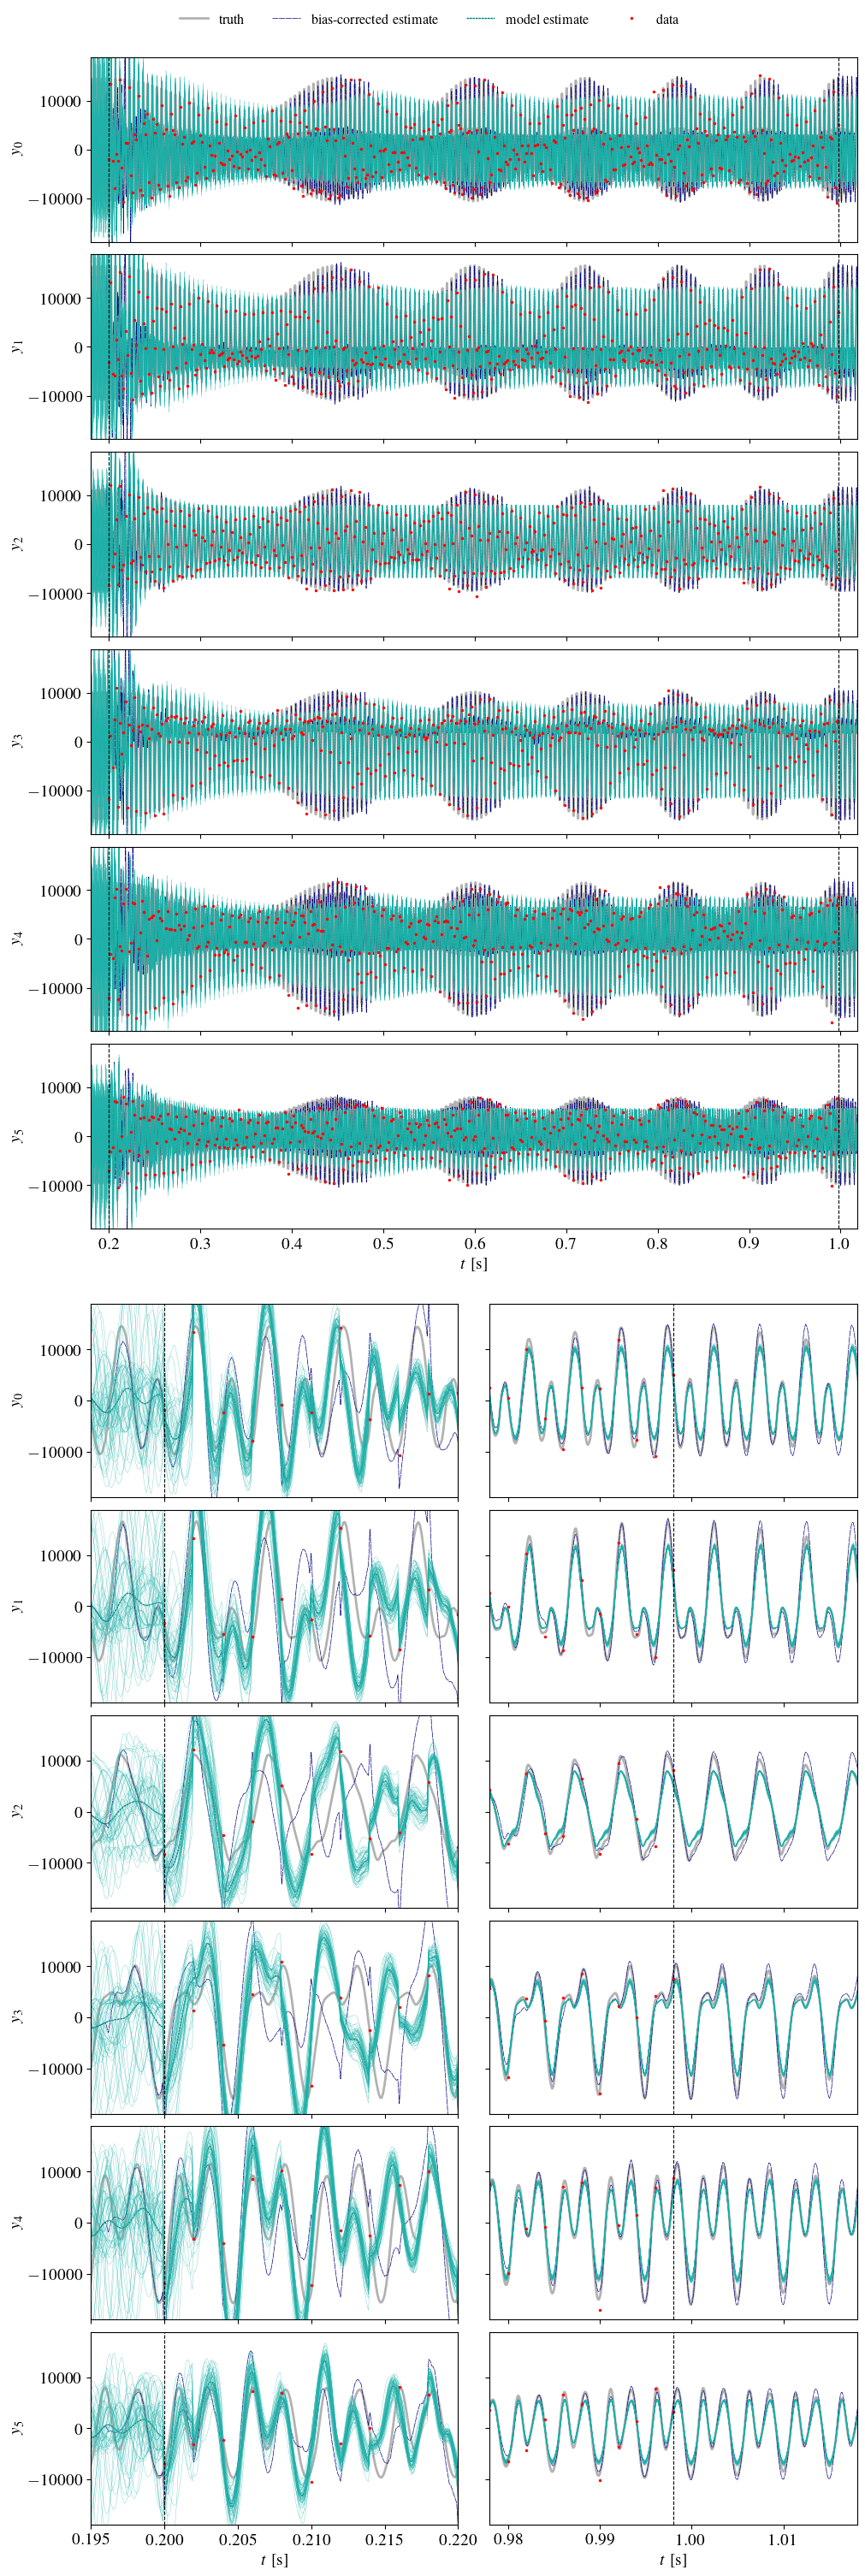

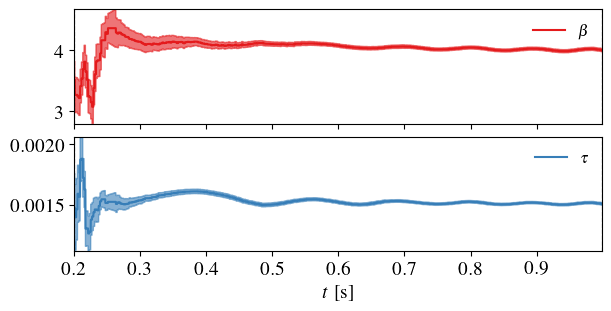

In [27]:
from essentials.plotResults import *

plot_timeseries(filter_ens, truth, plot_ensemble_members=True)
plot_parameters(filter_ens, truth)